## Составление прогноза потребления электроэнергии в ОЭС Средней Волги

Перед нами стяла задача составления краткосрочного прогноза потребления электроэнергии.

Выбрано две метрики качества: MAE и MAPE

В качестве возможных моделей будет рассмотренно несколько вариантов:
 - Константная модель
 - Наивная модель
 - Простая модель линейной регрессии
 - Сложная модель линейной регрессии (учет дополнительных факторов и лаговых значений показателей)
 - Сложная модель линейной регрессии с регуляризацией

In [1]:
import sys
import time
import datetime as dt
import warnings
import requests
import json
import math
import pickle
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 120)

print(f"Pandas version: {pd.__version__}")
print(f"Python version: {'.'.join(list(map(str, sys.version_info[:3])))}")
print(f"Scikit-learn version: {sklearn.__version__}")

DATA = 'data-prepare' + os.sep

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(dt.datetime.now().strftime("\n%Y-%m-%d %H:%M:%S"))

Pandas version: 1.1.3
Python version: 3.7.7
Scikit-learn version: 0.23.2

2020-12-24 10:51:39


## Подготовка данных для модели

In [2]:
"""
Загружаем подготовленные данные по средней температуре ОЭС Средней Волги (переводим в градусы Цельсия)
"""

temp = pd.read_csv(DATA + 'temp_volga_day.csv', sep=';')
temp['TEMP'] = round((temp['TEMP'] - 32) * 5 / 9, 1)
temp.describe()

,YEAR,MONTH,DAY,TEMP,VISIB
count,2125.000000,2125.000000,2125.000000,2125.000000,2125.000000
mean,2017.477647,6.436235,15.654588,6.062306,28.033714
std,1.683277,3.410727,8.823293,11.256867,55.847506
min,2015.000000,1.000000,1.000000,-26.000000,2.421378
25%,2016.000000,3.000000,8.000000,-2.600000,7.740000
50%,2017.000000,6.000000,16.000000,6.400000,9.549506
75%,2019.000000,9.000000,23.000000,16.100000,11.270370
max,2020.000000,12.000000,31.000000,28.400000,448.533333


In [3]:
"""
Загружаем подготовленные данные по планируемому и фактическому потреблению электроэнергии
"""

gen = pd.read_csv(DATA + 'gen_consum_volga.csv', sep=';')
gen.describe()

,Unnamed: 0,YEAR,MONTH,DAY,E_USE_FACT,E_USE_PLAN,GEN_FACT,GEN_PLAN
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,926.500000,2017.864617,6.586300,15.709817,41581.457751,41709.479339,42374.464237,42448.454925
std,535.348018,1.476021,3.466725,8.793300,4394.955376,4401.777208,4528.160156,4535.835284
min,0.000000,2015.000000,1.000000,1.000000,33321.097222,33549.972222,34190.736111,34345.277778
25%,463.250000,2017.000000,4.000000,8.000000,37612.881944,37697.052083,38287.475694,38331.663194
50%,926.500000,2018.000000,7.000000,16.000000,41320.194444,41479.729167,42106.097222,42202.729167
75%,1389.750000,2019.000000,10.000000,23.000000,45593.013889,45742.520833,46380.000000,46465.187500
max,1853.000000,2020.000000,12.000000,31.000000,50522.569444,50498.486111,51630.180556,51752.736111


In [4]:
"""
Загружаем данные по индексу самоизоляции (Яндекс)
"""

izol = pd.read_csv(DATA + 'izol_volga_day.csv', sep=';')
izol_d = {dt.datetime(int(x['YEAR']), int(x['MONTH']), int(x['DAY'])):x['INDEX'] for _, x in izol.iterrows()}
izol.describe()

,YEAR,MONTH,DAY,INDEX
count,278.0,278.000000,278.000000,278.000000
mean,2020.0,6.809353,15.856115,1.829871
std,0.0,2.640216,8.812578,0.750170
min,2020.0,2.000000,1.000000,0.830556
25%,2020.0,5.000000,8.000000,1.200309
50%,2020.0,7.000000,16.000000,1.505324
75%,2020.0,9.000000,23.750000,2.518596
max,2020.0,11.000000,31.000000,3.809414


In [5]:
"""
Загружаем данные по индексу потребительских цен (Сбериндекс)
"""

coms = pd.read_csv(DATA + 'sberindex_comsumer.csv', sep=';').groupby('Дата').mean().reset_index()
coms['DATE'] = pd.to_datetime(coms['Дата'], format='%Y-%m-%d')
coms['INDEX'] = coms['Значение']
coms = coms[['DATE', 'INDEX']]
coms_d = {x['DATE']:x['INDEX'] for _, x in coms.iterrows()}
coms.describe()

,INDEX
count,362.000000
mean,70.261203
std,12.875730
min,15.222222
25%,63.111111
50%,72.722222
75%,79.638889
max,100.000000


In [6]:
"""
Загружаем данные по индексу активности малого и среднего бизнеса (Сбериндекс)
"""

msp = pd.read_csv(DATA + 'sberindex_msp_activity.csv', sep=';').groupby('DATE').mean().reset_index()
msp['DATE'] = pd.to_datetime(msp['DATE'], format='%Y-%m-%d')
msp_d = {x['DATE']:x['VALUE'] for _, x in msp.iterrows()}
msp.describe()

,VALUE
count,38.000000
mean,-6.483626
std,11.316611
min,-33.233333
25%,-12.650000
50%,-0.450000
75%,2.230556
max,2.977778


In [7]:
"""
Объединяем данные в один датафрейм для дальнейшей обработки
"""

data = pd.DataFrame(columns=['YEAR', 'MONTH', 'DAY', 'WEEKDAY', 'USE_FACT', 'TEMP', 'VISIB', 'II', 'COMS', 'MSP'])

def get_date(df, loc):
    return dt.datetime(int(df.loc[loc]['YEAR']), int(df.loc[loc]['MONTH']), int(df.loc[loc]['DAY']))

temp_count = 0
date_temp = 0

ii_cur = 2
coms_cur = 70
msp_cur = 0


for k, v in gen.iterrows():
    yy = int(v['YEAR'])
    mm = int(v['MONTH'])
    dd = int(v['DAY'])
    
    date_gen = dt.datetime(yy, mm, dd)
    
    wd = date_gen.weekday()
    use = v['E_USE_FACT']
    
    
    date_temp = get_date(temp, temp_count)
    while temp_count < len(temp) - 1 and date_temp < date_gen:
        temp_count += 1
        date_temp = get_date(temp, temp_count)
    

    if date_gen in izol_d:
        ii_cur = izol_d[date_gen]
    
    if date_gen in coms_d:
        coms_cur = coms_d[date_gen]

    if date_gen in msp_d:
        msp_cur = msp_d[date_gen]
        
    tt = temp.loc[temp_count]['TEMP']
    vs = temp.loc[temp_count]['VISIB']
    
   
    data.loc[k] = [yy, mm, dd, wd, use, tt, vs, ii_cur, coms_cur, msp_cur]
print("Data shape:", data.shape)
data.head(3)

Data shape: (1854, 10)


,YEAR,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB,II,COMS,MSP
0,2015.0,11.0,1.0,6.0,42143.708333,-0.6,7.613333,2.0,70.0,0.0
1,2015.0,11.0,2.0,0.0,44020.416667,2.3,6.420000,2.0,70.0,0.0
2,2015.0,11.0,3.0,1.0,43557.458333,5.0,5.366667,2.0,70.0,0.0


In [8]:
"""
Обрезаем данные за последний день - по электроэнергетике не полные данные
"""

data = data[:len(data) - 1]
data.describe()

,YEAR,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB,II,COMS,MSP
count,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000
mean,2017.863465,6.583918,15.703724,2.998381,41582.890368,5.757906,25.053694,1.974476,70.051028,-0.924423
std,1.475585,3.466143,8.791758,2.000944,4395.708723,11.203483,45.462801,0.296417,5.685610,4.807393
min,2015.000000,1.000000,1.000000,0.000000,33321.097222,-23.700000,2.421378,0.830556,15.222222,-33.233333
25%,2017.000000,4.000000,8.000000,1.000000,37612.125000,-2.900000,8.303333,2.000000,70.000000,0.000000
50%,2018.000000,7.000000,16.000000,3.000000,41323.791667,5.500000,9.787654,2.000000,70.000000,0.000000
75%,2019.000000,10.000000,23.000000,5.000000,45596.027778,15.700000,11.368519,2.000000,70.000000,0.000000
max,2020.000000,12.000000,31.000000,6.000000,50522.569444,28.400000,345.200000,3.809414,100.000000,2.977778


## Константный бейзлайн

In [9]:
baseline = data[['USE_FACT']]
baseline['PREDICT'] = data['USE_FACT'].mean()
print(f"Constant baseline:",
    f"MAE ={mean_absolute_error(baseline['USE_FACT'].values, baseline['PREDICT'].values):8.2f},",
    f"MAPE ={mean_absolute_percentage_error(baseline['USE_FACT'].values, baseline['PREDICT'].values):5.2f}")

Constant baseline: MAE = 3921.94, MAPE = 9.51


## Наивный бейзлайн: прогноз на следующий день = фактическому потреблению

In [10]:
for i in range(1,6):
    baseline = data[['USE_FACT']]
    baseline['PREDICT'] = data['USE_FACT'].shift(i)
    baseline = baseline[i:]
    print(f"Constant baseline {i} day:",
        f"MAE ={mean_absolute_error(baseline['USE_FACT'].values, baseline['PREDICT'].values):8.2f},",
        f"MAPE ={mean_absolute_percentage_error(baseline['USE_FACT'].values, baseline['PREDICT'].values):5.2f}")

Constant baseline 1 day: MAE =  679.69, MAPE = 1.65
Constant baseline 2 day: MAE = 1103.20, MAPE = 2.68
Constant baseline 3 day: MAE = 1189.84, MAPE = 2.88
Constant baseline 4 day: MAE = 1236.86, MAPE = 2.99
Constant baseline 5 day: MAE = 1263.50, MAPE = 3.05


# Построение модели линейной регрессии

In [11]:
"""
Показатели качества предсказания модели на 5 дней
"""

def print_metric():
    for day in range(5):
        original = np.expm1(Y_train[Y_train.columns[day]].values)
        predict  = np.expm1(Y_predict[:,day])
        print(f'Predict for {day + 1} days: MAE={mean_absolute_error(original, predict):.2f},'
              f'R2={r2_score(original, predict):.2f}, MAPE={mean_absolute_percentage_error(original, predict):.2f}')

In [12]:
"""
Формируем датафрейм для дальнейшего использования
"""

data_train = pd.DataFrame()
for r, d in data.iterrows():
    data_train.loc[r, "DATE"] = dt.datetime(int(d["YEAR"]), int(d["MONTH"]), int(d["DAY"]))
    data_train.loc[r, "MONTH"] = int(d["MONTH"])
    data_train.loc[r, "DAY"] = int(d["DAY"])
    data_train.loc[r, "WEEKDAY"] = int(d["WEEKDAY"])
    data_train.loc[r, "USE_FACT"] = np.log1p(d["USE_FACT"])
    data_train.loc[r, "TEMP"] = d["TEMP"]
    data_train.loc[r, "VISIB"] = d["VISIB"]
    data_train.loc[r, "II"] = d["II"]
    data_train.loc[r, "COMS"] = d["COMS"]
    data_train.loc[r, "MSP"] = d["MSP"]
data_train.head(3)

,DATE,MONTH,DAY,WEEKDAY,USE_FACT,TEMP,VISIB,II,COMS,MSP
0,2015-11-01,11.0,1.0,6.0,10.648864,-0.6,7.613333,2.0,70.0,0.0
1,2015-11-02,11.0,2.0,0.0,10.692432,2.3,6.420000,2.0,70.0,0.0
2,2015-11-03,11.0,3.0,1.0,10.681859,5.0,5.366667,2.0,70.0,0.0


In [13]:
"""
Формируем лаговые переменные. 
"""

data_train3m = pd.DataFrame()
for r, d in data_train[30:len(data_train) - 5].iterrows():
    data_train3m.loc[r, "DATE"] = d["DATE"]
    data_train3m.loc[r, "WEEKDAY"] = d["WEEKDAY"]
    data_train3m.loc[r, "USE_FACT"] = d["USE_FACT"]
    data_train3m.loc[r, "TEMP"] = d["TEMP"]

    data_train3m.loc[r, "USE_FACT1"]  = data_train.loc[r - 1, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT5"]  = data_train.loc[r - 5, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT7"]  = data_train.loc[r - 7, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT14"] = data_train.loc[r - 14, "USE_FACT"]
    data_train3m.loc[r, "USE_FACT30"] = data_train.loc[r - 30, "USE_FACT"]
    
    data_train3m.loc[r, "TEMP1"] = data_train.loc[r - 1]["TEMP"]
    data_train3m.loc[r, "TEMP2"] = data_train.loc[r - 2]["TEMP"]
    data_train3m.loc[r, "TEMP3"] = data_train.loc[r - 3]["TEMP"]
    data_train3m.loc[r, "TEMP5"] = data_train.loc[r - 5]["TEMP"]

    data_train3m.loc[r, "II"] = data_train.loc[r]["II"]
    data_train3m.loc[r, "II3"] = data_train.loc[r - 3]["II"]

    data_train3m.loc[r, "COMS"] = data_train.loc[r]["COMS"]

    data_train3m.loc[r, "MSP"] = data_train.loc[r]["MSP"]
        
    data_train3m.loc[r, "USE_PRED1"]  = data_train.loc[r + 1, "USE_FACT"]
    data_train3m.loc[r, "USE_PRED2"]  = data_train.loc[r + 2, "USE_FACT"]
    data_train3m.loc[r, "USE_PRED3"]  = data_train.loc[r + 3, "USE_FACT"]
    data_train3m.loc[r, "USE_PRED4"]  = data_train.loc[r + 4, "USE_FACT"]
    data_train3m.loc[r, "USE_PRED5"]  = data_train.loc[r + 5, "USE_FACT"]

data_train3m = pd.get_dummies(data_train3m, columns=["WEEKDAY"], drop_first=True)
data_train3m.head(3)

,DATE,USE_FACT,TEMP,USE_FACT1,USE_FACT5,USE_FACT7,USE_FACT14,USE_FACT30,TEMP1,TEMP2,TEMP3,TEMP5,II,II3,COMS,MSP,USE_PRED1,USE_PRED2,USE_PRED3,USE_PRED4,USE_PRED5,WEEKDAY_1.0,WEEKDAY_2.0,WEEKDAY_3.0,WEEKDAY_4.0,WEEKDAY_5.0,WEEKDAY_6.0
30,2015-12-01,10.735145,0.1,10.735573,10.739441,10.740813,10.748621,10.648864,-2.2,-5.5,-5.2,-3.2,2.0,2.0,70.0,0.0,10.736356,10.739927,10.741679,10.703149,10.683180,1,0,0,0,0,0
31,2015-12-02,10.736356,-0.4,10.735145,10.743705,10.738559,10.752965,10.692432,0.1,-2.2,-5.5,-6.0,2.0,2.0,70.0,0.0,10.739927,10.741679,10.703149,10.683180,10.725968,0,1,0,0,0,0
32,2015-12-03,10.739927,-1.4,10.736356,10.709600,10.739441,10.758440,10.681859,-0.4,0.1,-2.2,-5.2,2.0,2.0,70.0,0.0,10.741679,10.703149,10.683180,10.725968,10.727333,0,0,1,0,0,0


## Создаем простую модель линейной регрессии

In [14]:
BACK = 90

BASE_COLUMN = ['USE_FACT', 'TEMP']

test_length = len(data_train3m) - BACK
X_train = data_train3m[:test_length][BASE_COLUMN]
Y_train = data_train3m[:test_length][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])
X_train.head(3)

,USE_FACT,TEMP
30,10.735145,0.1
31,10.736356,-0.4
32,10.739927,-1.4


In [15]:
Y_train.head(3)

,USE_PRED1,USE_PRED2,USE_PRED3,USE_PRED4,USE_PRED5
DATE,,,,,
2015-12-01,10.736356,10.739927,10.741679,10.703149,10.683180
2015-12-02,10.739927,10.741679,10.703149,10.683180,10.725968
2015-12-03,10.741679,10.703149,10.683180,10.725968,10.727333


In [16]:
lr = LinearRegression()
lr.fit(X_train.values, Y_train.values)
Y_predict = lr.predict(X_train)
print(lr.coef_)

[[ 0.87290019 -0.00106724]
 [ 0.7559514  -0.00203374]
 [ 0.73128577 -0.00221324]
 [ 0.72691631 -0.00220599]
 [ 0.73699391 -0.00207322]]


Проверка на **holdout** данных

In [17]:
X_train = data_train3m[test_length:][BASE_COLUMN]
Y_train = data_train3m[test_length:][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])

Y_predict = lr.predict(X_train)
print_metric()

Predict for 1 days: MAE=556.89,R2=0.92, MAPE=1.39
Predict for 2 days: MAE=830.43,R2=0.87, MAPE=2.07
Predict for 3 days: MAE=867.04,R2=0.85, MAPE=2.16
Predict for 4 days: MAE=927.27,R2=0.84, MAPE=2.29
Predict for 5 days: MAE=996.95,R2=0.82, MAPE=2.44


## Построение сложной модели, учитывающей значения лаговых переменных и дополнительные факторы, влияющие на потребление электроэнергии

In [18]:
BACK = 90
test_length = len(data_train3m) - BACK
X_train = data_train3m[:test_length].drop(columns=["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"])
Y_train = data_train3m[:test_length][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])
X_train.head(3)

,USE_FACT,TEMP,USE_FACT1,USE_FACT5,USE_FACT7,USE_FACT14,USE_FACT30,TEMP1,TEMP2,TEMP3,TEMP5,II,II3,COMS,MSP,WEEKDAY_1.0,WEEKDAY_2.0,WEEKDAY_3.0,WEEKDAY_4.0,WEEKDAY_5.0,WEEKDAY_6.0
30,10.735145,0.1,10.735573,10.739441,10.740813,10.748621,10.648864,-2.2,-5.5,-5.2,-3.2,2.0,2.0,70.0,0.0,1,0,0,0,0,0
31,10.736356,-0.4,10.735145,10.743705,10.738559,10.752965,10.692432,0.1,-2.2,-5.5,-6.0,2.0,2.0,70.0,0.0,0,1,0,0,0,0
32,10.739927,-1.4,10.736356,10.709600,10.739441,10.758440,10.681859,-0.4,0.1,-2.2,-5.2,2.0,2.0,70.0,0.0,0,0,1,0,0,0


In [19]:
Y_train.head(3)

,USE_PRED1,USE_PRED2,USE_PRED3,USE_PRED4,USE_PRED5
DATE,,,,,
2015-12-01,10.736356,10.739927,10.741679,10.703149,10.683180
2015-12-02,10.739927,10.741679,10.703149,10.683180,10.725968
2015-12-03,10.741679,10.703149,10.683180,10.725968,10.727333


In [20]:
lr = LinearRegression()
lr.fit(X_train.values, Y_train.values)
Y_predict = lr.predict(X_train)
print(lr.coef_)

[[ 9.51782389e-01 -7.16181196e-04 -3.76196033e-02  1.11960178e-01
  -7.22481984e-02  3.13014644e-02 -2.88826497e-02  5.19664095e-04
  -3.42075908e-04  1.06957435e-04  1.11765091e-04 -2.40341412e-03
   2.61768192e-05 -3.02698142e-04  3.13705478e-04  5.24143625e-04
   1.13361695e-03  3.49221747e-03 -2.40768934e-02 -1.61810793e-02
   3.67272959e-02]
 [ 8.23742626e-01 -9.81333656e-04  4.92154973e-02  1.63761929e-01
  -1.11760507e-01  5.81921801e-02 -5.54075637e-02  5.34822511e-04
  -3.86838202e-04  1.64284002e-04  1.69886566e-04 -4.79891051e-03
  -6.29480314e-04 -5.70308292e-04  5.49339608e-04 -4.07200760e-03
  -3.57752756e-03 -2.89827726e-02 -4.03138169e-02  1.71541700e-02
   3.09386097e-02]
 [ 7.70786305e-01 -1.16628989e-03  9.93370551e-02  1.11857766e-01
  -7.87652907e-02  8.80293388e-02 -8.43745804e-02  5.76997262e-04
  -3.73556043e-04  1.82725884e-04  1.70233468e-04 -7.24030056e-03
  -1.60438020e-04 -7.82335782e-04  7.46248292e-04 -7.91053767e-03
  -3.57601788e-02 -4.72251318e-02 -3.0


### Валидация сложной модели на неизвестных данных

In [21]:
X_train = data_train3m[test_length:].drop(columns=["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"])
Y_train = data_train3m[test_length:][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])

In [22]:
Y_predict = lr.predict(X_train.values)
print_metric()

Predict for 1 days: MAE=186.00,R2=0.99, MAPE=0.46
Predict for 2 days: MAE=296.67,R2=0.98, MAPE=0.73
Predict for 3 days: MAE=393.87,R2=0.97, MAPE=0.97
Predict for 4 days: MAE=465.86,R2=0.96, MAPE=1.14
Predict for 5 days: MAE=503.32,R2=0.95, MAPE=1.22


In [23]:
%%timeit
Y_predict = lr.predict(X_train.values)

95.3 µs ± 525 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


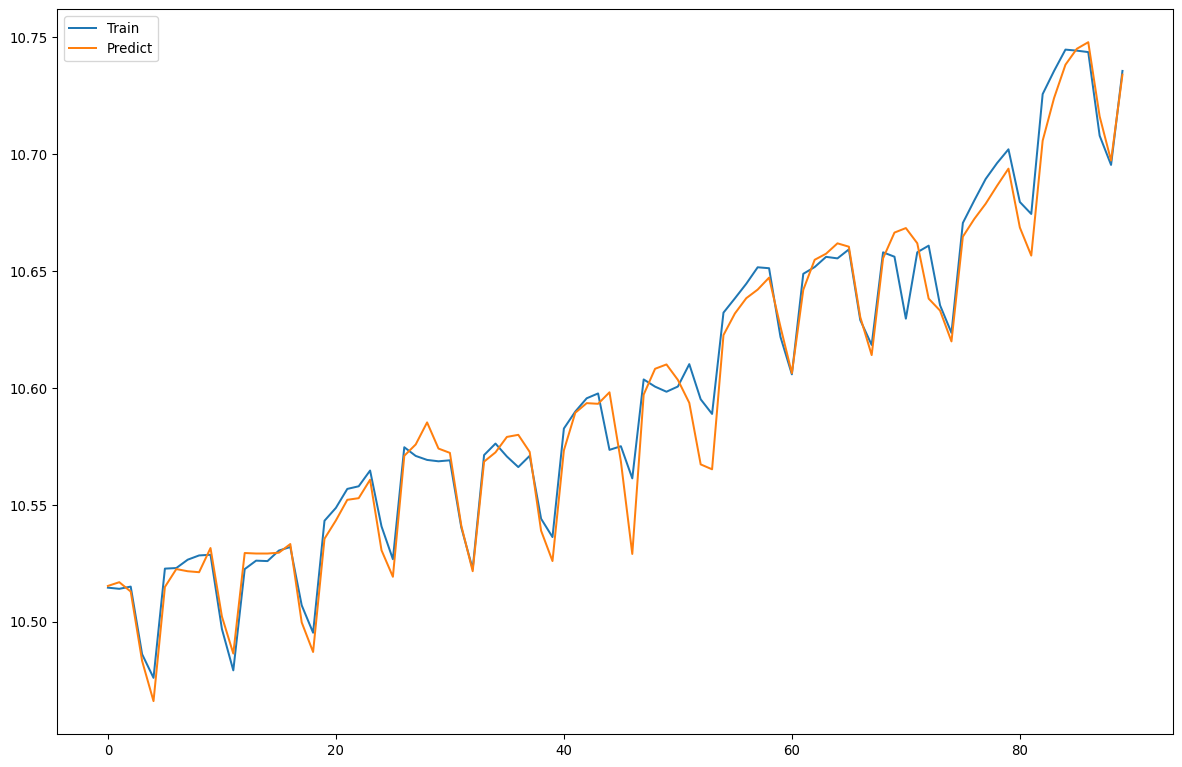

In [24]:
plt.figure(figsize=(15, 10), dpi=96)
plt.plot(np.array(Y_train.reset_index()["USE_PRED2"]),label='Train')
plt.plot(Y_predict[:,1],label='Predict')
plt.legend()
plt.show()

In [25]:
"""Сохраняем данные и обученную модель"""

with open('model_data.pkl', 'wb') as handle:
    pickle.dump({'model': lr, 'data':data_train3m.set_index(data_train3m['DATE'])}, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Добавление в модель l2 регуляризации

In [26]:
BACK = 90
test_length = len(data_train3m) - BACK
X_train = data_train3m[:test_length].drop(columns=["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"])
Y_train = data_train3m[:test_length][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])

ridge = Ridge(alpha=0.15)
ridge.fit(X_train.values, Y_train.values)

X_train = data_train3m[test_length:].drop(columns=["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"])
Y_train = data_train3m[test_length:][["DATE", "USE_PRED1", "USE_PRED2", "USE_PRED3", "USE_PRED4", "USE_PRED5"]]
Y_train = Y_train.set_index(Y_train["DATE"]).drop(columns=["DATE"])

Y_predict = ridge.predict(X_train.values)
print_metric()

Predict for 1 days: MAE=200.03,R2=0.99, MAPE=0.50
Predict for 2 days: MAE=307.38,R2=0.98, MAPE=0.76
Predict for 3 days: MAE=404.44,R2=0.97, MAPE=0.99
Predict for 4 days: MAE=475.78,R2=0.95, MAPE=1.16
Predict for 5 days: MAE=508.57,R2=0.95, MAPE=1.23


## Выводы

 - Константная модель дает огромную погрешность в прогнозе
 - Точность наивной модели по MAPE равна 1.65, это является хорошим ориентиром
 - Простая линейная модель хорошо улучшает прогноз наивой модели, например при прогнозе на три дня<br> значение метрики MAPE уменьшилось с 2,88 до 2,16
 - Сложная модель линейной регрессии значительно превосходит простую модель линейной регрессии, например<br> при прогнозе на три дня значение метрики MAPE уменьшилось с 2,16 до 0,97, а при прогнозе на 5 дней &mdash; с 2,44 до 1,22
 - Сложная модель с l2 регуляризацией не дала качественного улучшения прогноза, по сравнению с моделью без регуляризации

Останавливаемся на сложной модели линейной регрессии.